In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Trabajo Práctico 1
Se buscó analizar si existe un sesgo en el dataset de snli donde el contenido mismo del texto puede estar delatando si existe una contradicción con respecto a la hipótesis oculta.
## Carga de Datos
Se cargaron los datasets correspondientes para observación, ya divididos en datos de entrenamiento, validación y prueba.

In [3]:
# Cargo los datos
df_train = pd.read_hdf("./train_data.hdf5")
df_valid = pd.read_hdf("./valid_data.hdf5")
df_test = pd.read_hdf("./test_data.hdf5")

In [ ]:
df_submission = pd.read_csv("/kaggle/input/sesgos-en-el-dataset-de-snli/submission_sample.csv", index_col="pairID")

In [5]:
text_train = df_train["text"].tolist()
labels_train = df_train["gold_label"].tolist()
text_val = df_valid["text"].tolist()
labels_val = df_valid["gold_label"].tolist()
text_test = df_test["text"].tolist()

In [6]:
#Veamos el balance de clases
from collections import Counter
Counter(labels_train)

Counter({'contradiction': 183187, 'entailment': 183416, 'neutral': 182764})

## Pre-procesamiento de Texto
+ NLTK (Natural Language Toolkit)
  + Lemmatization: reduce a sus significados (ej, quita conjugación verbal)
  + Stop Words: quita preposiciones (como palabras muy usuales de relleno?)
  + Stemming: reduce las palabras a su raíz
  + Filtrado de no palabras

In [7]:
# Paquetes de Natural Language Tool Kit
import nltk
#Tokenización (a partir de este se trabajan las otras combinacionies)
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ohvic\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ohvic\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ohvic\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [8]:
# Función con la cual también decido cómo pre-procesar
def text_filter(dataset, do_lemm, do_stop, do_stem, do_alpha):
    texts_filtrados = list()
    for idx in range(len(dataset.text)):
        if idx%100==0:
            print("\r Procesados: {}".format(idx),end="")
        em = dataset.text[idx]
        tok = word_tokenize(em)
        if do_lemm == True:
            lem = [lemmatizer.lemmatize(x,pos='v') for x in tok]
        else:
            lem = tok
        if do_stop == True:
            stop = [x for x in lem if x not in stopwords.words('english')]
        else:
            stop = lem
        if do_stem == True:
            stem = [stemmer.stem(x) for x in stop]
        else:
            stem = stop
        if do_alpha == True:
            alpha = [x for x in stem if x.isalpha()]
        else:
            alpha = stem
        texts_filtrados.append(" ".join(alpha))
    return texts_filtrados

## Vectorizadores
+ Count Vectorizer
+ TFIDF Vectorizer

In [9]:
#Importo los vectorizadores
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [10]:
df_max = 1.0 # max_df: int para frecuencia contada, float para proporcional
df_min = 10 # min_df: idem
n_range = (1,1) # ngram_range: (1,1) default
cv_cv = CountVectorizer(max_df = df_max, min_df= df_min, ngram_range = n_range)

In [11]:
df_max = 1.0
df_min = 10
n_range = (1,1)
cv_idf = TfidfVectorizer(max_df = df_max, min_df= df_min, ngram_range = n_range)

In [12]:
def get_cvs(text_train, text_valid, cv):
    cv_train = cv.fit_transform(text_train)
    cv_valid = cv.transform(text_valid)
    return cv_train, cv_valid

## Calisificadores
+ Multinomial Naive-Bayes
+ Regresión Logística (MLP)

### Multinomial Naive-Bayes

In [13]:
from sklearn.naive_bayes import MultinomialNB

In [14]:
# Parámetros del Clasificador
a = 1e-10
clf_NBMN = MultinomialNB(alpha = a)

### Multilevel Perceptrons

In [15]:
import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense

# WIP
model = Sequential()
model.add(Dense(hidden_units, input_shape=(input_dim,), activation='relu'))
model.add(Dense(10, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

# Dimm capa entrada: num de vocablos
# Dimm capa salida: 3

# Métricas
Las metricas de evaluacion que se utilizan para evaluar un metodo de clasificacion y ademas comparar varios metodos de clasificacion aplicados a un mismo conjunto de datos. Tambien se puede evaluar el comportamiento dado por un cambio de parametros en un metodo. 
La evaluacion del modelo se hace a partir de los datos que se encuentran en test, siendo clasidicacion supervisada. 
Hay que considerar los distintos tipos de datos para las metricas de evaluacion: 

	* Verdaderos positivos: El valor real es positivo y  la prueba predijo tambien que era positivo.
	* Verdaderos Negativos: El valor real  es negativo y la prueba predijo tambien que el resultado era negativo.
	* Falsos positivos: El valor real es negativo, y la prueba predijo  que el resultado es positivo. 
	* Falsos negativos: El valor real es positivo, y la prueba predijo  que el resultado es negativo. 

Se utilizaron metricas para la evaluacion del rendimiento, siendo estas:
	* precision
	* recall_score
	* f1_score
	* ROC AUG
Ninguno de estos criterios por separado da una buena evaluacion de un metodo de clasificacion y hay que utilizar varios criterios al mismo tiempo.

La curva ROC es el grafico de la tasa de verdaderos positivos contra la tasa de falsos positivos. Luego es posible analizar el error en la clasificacion midiendo el area debajo de la curva. Cuanto mas cerca de 1 este el area, mejor sera la clasificacion. El area debajo de la curva ROC o AUG es una metrica que puede ser
utilizada para comparar diferentes test de clasificacion. Es una medida de la precision del test. Se calcula con un metodo de integracion numerica.

Se calcularon todas pero a la hora de pensar en la robustez de un metodo hay que tener en cuenta las ventajas y las desventajas que tiene cada uno de las metricas. 
Con la métrica de precisión podemos medir la calidad del modelo de machine learning en tareas de clasificación. Se refiere a la dispersión del conjunto de valores obtenidos a partir de mediciones repetidas de una magnitud. Cuanto menor es la dispersión mayor la precisión. Se representa por la proporción de verdaderos positivos dividido entre todos los resultados positivos (tanto verdaderos positivos, como falsos positivos).

$$precision = \frac{TP}{TP + FP}$$

La métrica de exhaustividad nos va a informar sobre la cantidad que el modelo de machine learning es capaz de identificar. Es tambien llamada tasa de verdaderos positivos es la probabilidad de que un resultado positivo real dé positivo.

$$recall = \frac{TP}{TP + FN}$$

El valor F1 se utiliza para combinar las medidas de precision y recall en un sólo valor. Esto es práctico porque hace más fácil el poder comparar el rendimiento combinado de la precisión y la exhaustividad entre varias soluciones. Es de gran utilidad cuando la distribución de las clases es desigual.
$$F1 = 2 \cdot \frac{precision \cdot recall}{precision + recall} $$

Hay otra metrica llamada *accuracy* que mide el porcentaje de casos que el modelo ha acertado. Esta no funciona bien cuando las clases están desbalanceadas. En este caso se pudo ver que las clases estaban bien balanceadas por lo que se opto la misma como metrica primaria. Si no hubiese sido asi, es decir las clases desbalanceadas, es mucho mejor usar precision, recall y F1. Estas métricas dan una mejor idea de la calidad del modelo.
$$accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

El sesgo es la diferencia entre el valor medio y el verdadero valor de la magnitud medida. El sesgo pertenece al concepto de exactitud.

Conforme a las metricas mencionadas podemos obtener cuatro casos posibles para cada clase:

* **Alta precisión y alto recall:** el modelo de Machine Learning escogido maneja perfectamente esa clase.
* **Alta precisión y bajo recall:** el modelo de Machine Learning escogido no detecta la clase muy bien, pero cuando lo hace es altamente confiable.
* **Baja precisión y alto recall:** El modelo de Machine Learning escogido detecta bien la clase,  pero también incluye muestras de la otra clase.
* **Baja precisión y bajo recall:** El modelo de Machine Learning escogido no logra clasificar la clase correctamente.

Para un *dataset* desequilibrado se puede caer en la obtencion de un alto valor de precisión en la clase Mayoritaria y un bajo recall en la clase Minoritaria. 

In [16]:
from sklearn import metrics

In [17]:
def get_scores(clf, X_train, y_train, X_valid, y_valid):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    
    score_train = clf.score(X_train, y_train)
    score_valid = clf.score(X_valid, y_valid)
    return (score_train, score_valid)
    
def get_metrics(clf, X_valid, y_valid):
    y_pred = clf.predict(X_test)
    m_conf = metrics.confusion_matrix(y_valid, y_pred)
    precision = metrics.precision_score(y_valid, y_pred)
    recall_score = metrics.recall_score(y_valid,y_pred)
    f1_score = metrics.f1_score(y_valid,y_pred)
    acc = metrics.accuracy_score(y_valid, y_pred)
    
    return score_train, score_valid, m_conf, precision, recall_score, f1_score, acc

In [18]:
# Función que hace todo lo anterior de una
def process_data(clf, cv, df_train, df_valid, do_lemm, do_stop, do_stem, do_alpha):
    print("\n  Filtrando Textos")
    texts_train = text_filter(df_train, do_lemm, do_stop, do_stem, do_alpha)
    texts_valid = text_filter(df_valid, do_lemm, do_stop, do_stem, do_alpha)
    
    labels_train = df_train["gold_label"].tolist()
    labels_valid = df_valid["gold_label"].tolist()
    
    print("\nVectorizando")
    cv_train, cv_valid = get_cvs(texts_train, texts_valid, cv)
    
    print("Obteniendo Puntajes")
    score_train, score_valid = get_scores(clf, cv_train, labels_train, cv_valid, labels_valid)
    return (cv_train, cv_valid, score_train, score_valid)

In [19]:
test_raw = process_data(clf_NBMN, cv_cv, df_train, df_valid, False, False, False, False)
test_lemm = process_data(clf_NBMN, cv_cv, df_train, df_valid, True, False, False, False)
test_stop = process_data(clf_NBMN, cv_cv, df_train, df_valid, False, True, False, False)
test_stem = process_data(clf_NBMN, cv_cv, df_train, df_valid, False, False, True, False)
test_alfa = process_data(clf_NBMN, cv_cv, df_train, df_valid, False, False, False, True)


  Filtrando Textos
 Procesados: 980000
Vectorizando
Obteniendo Puntajes

  Filtrando Textos
 Procesados: 980000
Vectorizando
Obteniendo Puntajes

  Filtrando Textos
 Procesados: 980000
Vectorizando
Obteniendo Puntajes

  Filtrando Textos
 Procesados: 980000
Vectorizando
Obteniendo Puntajes

  Filtrando Textos
 Procesados: 980000
Vectorizando
Obteniendo Puntajes


In [20]:
print("Train/Valid:")
print("raw:  ",  test_raw[2],"; ",  test_raw[3])
print("lemm: ", test_lemm[2],"; ", test_lemm[3])
print("stop: ", test_stop[2],"; ", test_stop[3])
print("stem: ", test_stem[2],"; ", test_stem[3])
print("alfa: ", test_alfa[2],"; ", test_alfa[3])

Train/Valid:
raw:   0.6220704920390194 ;  0.6228408859987807
lemm:  0.6174324267748154 ;  0.6197927250558829
stop:  0.6136462510489346 ;  0.6184718553139605
stem:  0.6168572193087681 ;  0.6187766714082503
alfa:  0.6215644550910412 ;  0.6224344645397277


Observando los resultados de estas pruebas, parece ser que aplicar cualquiera de los filtros de lenguaje natural resulta en una disminusión en la capacidad del modelo de predecir correctamente los resultados deseados. Esto puede deberse a que existe información dentro de cada elemento eliminado que podría llevar a concluir si la frase es contradictoria, neutral o afirmativa.

Debido a esto, se procederá a trabajar con los datos sin aplicar los filtros del paquete NLTK.

In [27]:
# Finalmente se trabaja sin filtros
text_train_final = text_train
text_valid_final = text_val

Definido el pre-procesamiento se analizó si se obtienen mejores resultados utilizando el CountVectorizer o TFIDFVectorizer.

In [28]:
df_max = 1.0 # max_df: int para frecuencia contada, float para proporcional
df_min = 10 # min_df: idem
n_range = (1,2) # ngram_range: (1,1) default

In [29]:
cv_cv = CountVectorizer(max_df = df_max, min_df= df_min, ngram_range = n_range)
cv_idf = TfidfVectorizer(max_df = df_max, min_df= df_min, ngram_range = n_range)

In [30]:
cv_train, cv_valid = get_cvs(text_train_final, text_valid_final, cv_cv)
cv_scores = get_scores(clf_NBMN, cv_train, labels_train, cv_valid, labels_val)
cv_train, cv_valid = get_cvs(text_train_final, text_valid_final, cv_idf)
idf_scores = get_scores(clf_NBMN, cv_train, labels_train, cv_valid, labels_val)

print(cv_scores)
print(idf_scores)

(0.6493109342206576, 0.638996138996139)
(0.6588510048838027, 0.6470229628124365)


Bajo las mismas condiciones el TFIDF Vectorizer parece tener un mejor rendimiento a la hora de predecir los resultados correctamente. Por lo tanto las siguientes pruebas se harán con el TFIDF.



In [31]:
# Hago un Sweep para optimizar el min_df
train_scores = list()
valid_scores = list()
df_mins = range(5,15,1)
for i in df_mins:
    cv = TfidfVectorizer(max_df = df_max, min_df= i, ngram_range = n_range)
    cv_train, cv_valid = get_cvs(text_train_final, text_valid_final, cv)
    scores = get_scores(clf_NBMN, cv_train, labels_train, cv_valid, labels_val)
    train_scores.append(scores[0])
    valid_scores.append(scores[1])

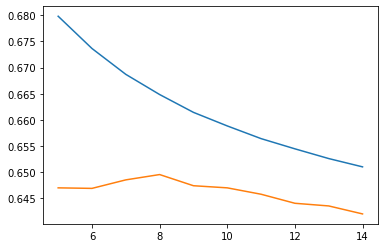

In [32]:
import matplotlib.pyplot as plt
plt.plot(df_mins,train_scores)
plt.plot(df_mins,valid_scores)

Con un min_df = 8 se obtuvo el score_valid más alto.

In [ ]:
# Puedo hacer el sweep para ver qué onda si cambio max_df

Algo pasa más arriba de acá

In [33]:
clf.fit(cv_train, labels_train)
labels_pred = clf.predict(cv_valid)

NameError: name 'clf' is not defined

In [ ]:
#Veamos cómo funciona el clasificador para train
clf.score(cv_train, labels_train)

In [ ]:
# Veamos cómo funciona el clasificador para valid
clf.score(cv_valid, labels_val)

In [ ]:
cv_test = cv.transform(text_test_final)
get_metrics(clf, cv_test, labels_test)
# test_labels = clf.predict(cv_test)

## Modelo Final

In [60]:
# Parámetros de Pre-procesamiento (sin procesamiento)
text_train_final = text_train
text_valid_final = text_val

# Parámetros del Count Vectorizer
df_max = 1.0 # max_df: int para frecuencia contada, float para proporcional
df_min = 8 # min_df: obtenido de una curva
n_range = (1,2) # ngram_range: (1,1) default

cv = TfidfVectorizer(max_df = df_max, min_df= df_min, ngram_range = n_range)

# Parámetros del Clasificador
a = 1e-4
clf = MultinomialNB(alpha = a)

cv_train = cv.fit_transform(text_train_final)
cv_val = cv.transform(text_valid_final)
clf.fit(cv_train, labels_train)

cv_test = cv.transform(text_test)
test_labels = clf.predict(cv_test)

get_metrics(clf, cv_val, labels_val)

## Métricas del modelo final

# Para armar Submission
Una vez elegido el grado de pre-procesamiento, el vectorizador y el clasificador, lo aplico sobre el el test.
+ Preprocesamiento: Lemmatization, Stemming y No-Palabras
+ Vectorizador: TFIDF
+ Clasificador: Multinomial Naive-Bayes

In [61]:
#Armo el submission.csv
df_test = pd.DataFrame(data=test_labels, columns=["pred_labels"],)

In [62]:
df_test.head()

In [63]:
df_test.index.names = ["pairID"]

In [64]:
df_test

In [65]:
df_test.to_csv("submission.csv")

# Conclusiones
A partir de las métricas obtenidas por el momento se puede decir que existe un sesgo en la selección de textos para la validación de premisas en el *dataset* de SNLI, dado que es posible obtener resultados correctos en el 65% de los casos, incluso con una baja cantidad de optimizaciones, a partir de solo las hipótesis y desconocer las premisas correspondientes.